In [1]:
import numpy as np
import brainpy.math as bm
import brainpy.math as bm
from scipy.signal import hilbert
from scipy import signal

#for plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

#import the model
from network_models import HDNet, HDParams
import plotting

%matplotlib inline
%load_ext autoreload
%autoreload 2

bm.set_dt(1.) 

In [2]:
def simulate_hdnet(net: HDNet, directions, velocity_gains, theta_strength=0, theta_cycle_len=100):
    """Simulate HDNet over a trajectory of directions and velocity gains."""
    def step(i, direction, velocity_gain):
        # theta oscillation phase
        t = i * bm.dt
        theta_phase = bm.mod(t, theta_cycle_len) / theta_cycle_len
        theta_phase = theta_phase * 2 * np.pi - np.pi

        # theta modulation
        theta_modulation = 1 + theta_strength * velocity_gain * bm.cos(theta_phase)

        # update network
        net.step_run(i, direction, theta_modulation)

        return net.center, net.r, theta_phase, theta_modulation

    return bm.for_loop(
        step,
        (bm.arange(len(directions)), directions, velocity_gains),
        progress_bar=True
    )


In [3]:
 # 1 ms

params = HDParams(adaptation_strength=10)
hd_net = HDNet(cell_num=100, params=params)   

numT = 2000
angular_velocity_gain = 1.0

direction = angular_velocity_gain * 2* bm.pi * bm.arange(numT) / numT
direction = bm.mod(direction, 2*bm.pi) - bm.pi
ang_speed = np.diff(direction)/bm.dt *1000
velocity_gains = bm.ones_like(direction) * angular_velocity_gain

# simulate the HD network
internal_direction, net_activity, theta_phase, theta_modulation = simulate_hdnet(
    hd_net, direction, velocity_gains, theta_strength=0.5, theta_cycle_len=100
)

#to numpy array
internal_direction = np.array(internal_direction)
net_activity = np.array(net_activity)
theta_phase = np.array(theta_phase)
theta_modulation = np.array(theta_modulation)

mean_net_activity = bm.mean(net_activity, axis=1)

2025-09-09 22:13:47.062090: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  0%|          | 0/2000 [00:00<?, ?it/s]

## Plot theta sweeps

/tmp/ipykernel_3688676/3818383135.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


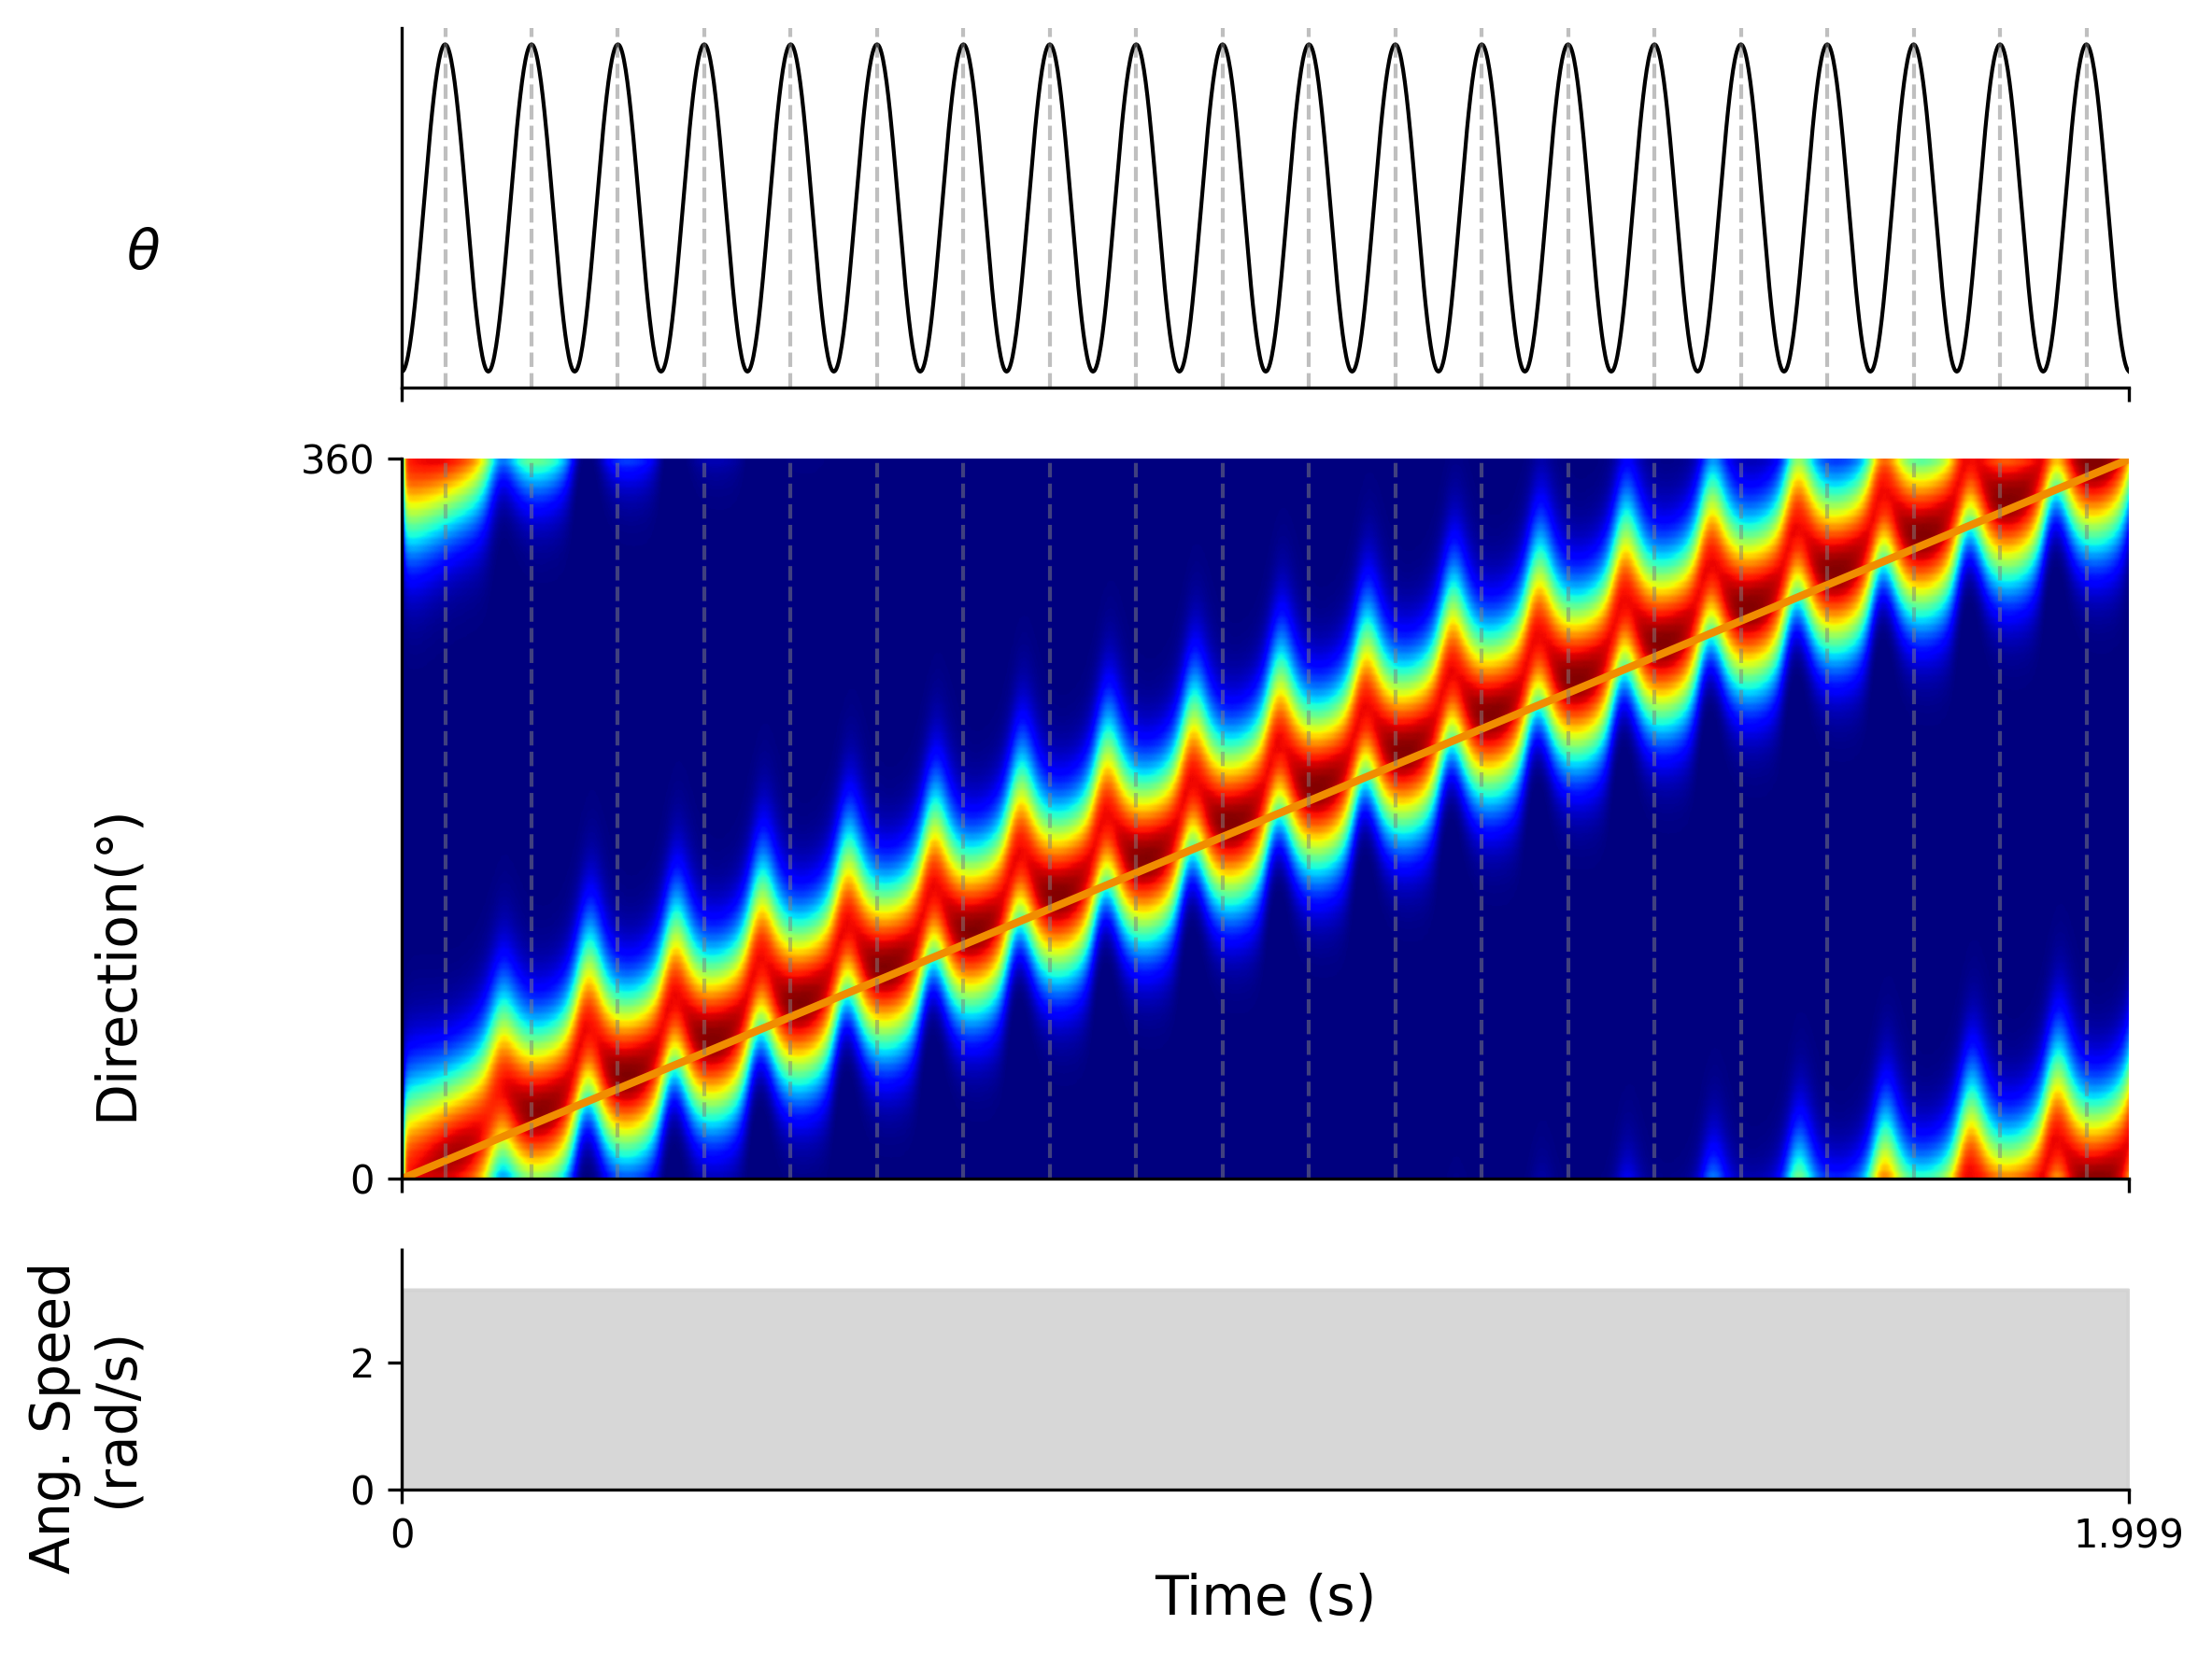

In [4]:
time_steps = np.arange(numT)

start = 0 #let the bump atcivity to built up in the CAN for the first 200 ms
end = numT

fig, axes = plt.subplots(
    3,
    1,
    figsize=(8, 6),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]},
    dpi=300,
)

ax = axes[0]
ax = plotting.plot_theta_modulation(ax, time_steps, theta_phase, theta_modulation, add_lines=True, atol=1e-2)

ax = axes[1]
ax = plotting.plot_population_activity(ax, time_steps, theta_phase, net_activity, direction, add_lines=True, atol=1e-2)

ax = axes[2]
ax = plotting.plot_angular_speed(ax, time_steps, ang_speed)


for ax in axes:
    sns.despine(ax=ax)
    #align ylabels vertically
    ax.yaxis.set_label_coords(-0.15, 0.3)  # Shift labels left (adjust as needed)
    #labelsize as 14
    ax.tick_params(axis='both', which='major', labelsize=10)
    #labelsize as 14
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)



plt.tight_layout()

## Plot spike phase as a function of turning angle, i.e., check theta phase coding

  0%|          | 0/30000 [00:00<?, ?it/s]

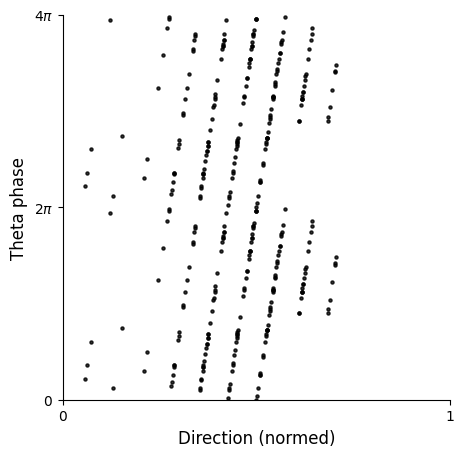

In [15]:

params = HDParams(adaptation_strength=10, conn_noise=1.0)
hd_net = HDNet(cell_num=100, params=params)   

numT = 30000 #need a long simulation here to get enough spikes
cycleT = 2000
angular_velocity_gain = 1.0

direction = angular_velocity_gain * 2* bm.pi * bm.arange(numT) / cycleT
direction = bm.mod(direction, 2*bm.pi) - bm.pi
velocity_gains = bm.ones_like(direction) * angular_velocity_gain

# simulate the HD network
internal_direction, net_activity, theta_phase, theta_modulation = simulate_hdnet(
    hd_net, direction, velocity_gains, theta_strength=0.5, theta_cycle_len=100
)

internal_direction = np.array(internal_direction)
net_activity = np.array(net_activity)
theta_phase = np.array(theta_phase)
theta_modulation = np.array(theta_modulation)

cell_num = hd_net.cell_num

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

# ax = plot_phaseprecession(ax, 10, bump_activity_downsampled, Actual_pos, theta_phase)

cell_index = 50
cell_activity = net_activity[:, cell_index]
pos_spike = []
tp_spike = []
#for each Head_direction, theta_phase pair, generate a spike event based on a Poisson process with mean value as r_HD
for i in range(len(direction)):
    pos = direction[i]
    tp = theta_phase[i]
    r = cell_activity[i] 
    #genertae a spike event based on a Poisson process with mean value as r
    spikes = np.random.poisson(r/10, 1)
    if spikes > 0:
        #save hd and tp
        pos_spike.append(pos)
        tp_spike.append(tp)
pos_spike = np.array(pos_spike)
tp_spike = np.array(tp_spike)

ax.scatter(pos_spike, tp_spike, s=5, color='black', alpha=0.8)

ax.scatter(pos_spike, tp_spike+2*np.pi, s=5, color='black', alpha=0.8)


# ax[0].set_xlabel('Head direction')
ax.set_xlabel('Direction (normed)', fontsize=12)
ax.set_ylabel('Theta phase', fontsize=12)
#activity colorbar
ax.set_xlim(-np.pi*2/3, np.pi*2/3)
ax.set_xticks([-np.pi*2/3, np.pi*2/3])
ax.set_xticklabels([0, 1])
ax.set_ylim(-np.pi, 3*np.pi)
ax.set_yticks([-np.pi, np.pi, 3*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])

#tick size
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



## Now let's use RatInABox to simulate some 'real' trajectories where the animal's head is keep rotating but with varying speed

/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/ratinabox/utils.py:891: UserWarning: Found 1 unexpected params key(s) while initializing Agent object: 'rotation_velocity_std'.
If you intended to set this parameter, ignore this message. To see all default parameters for this class call Agent.get_all_default_params().
  warnings.warn(
100%|██████████| 10000/10000 [00:05<00:00, 1972.54it/s]


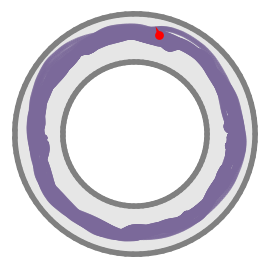

In [14]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from tqdm import tqdm

Env = Environment(
    params={
    'boundary':[[0.5*np.cos(t),0.5*np.sin(t)] for t in np.linspace(0,2*np.pi,100)],
    'holes':[[[0.3*np.cos(t),0.3*np.sin(t)] for t in np.linspace(0,2*np.pi,100)]],
    })

Ag = Agent(Env,params={'dt':0.001, 'speed_mean':3, 'speed_std':0.5, 'speed_coherence_time':0.08,
                      'rotation_velocity_std':180*np.pi/180, 'rotational_velocity_coherence_time':0.01})


for i in tqdm(range(int(10/ Ag.dt))): 
    Ag.update()
    
Ag.plot_trajectory(framerate=1000)
# Ag.animate_trajectory(framerate=1000)

#get the head direction
direction = Ag.history["head_direction"]
#to numpy
direction = np.array(direction)
#calculate the angle
direction = np.arctan2(direction[:,1], direction[:,0])
#calculate ang_speed
# unwrap to remove jumps at -pi/pi
direction_unwrapped = np.unwrap(direction)
# angular speed = derivative of continuous angle
ang_speed = np.diff(direction_unwrapped) / Ag.dt
#add 0 at the beginning to make the length same as direction
ang_speed = np.insert(ang_speed, 0, 0)

Text(0, 0.5, 'Direction (rad)')

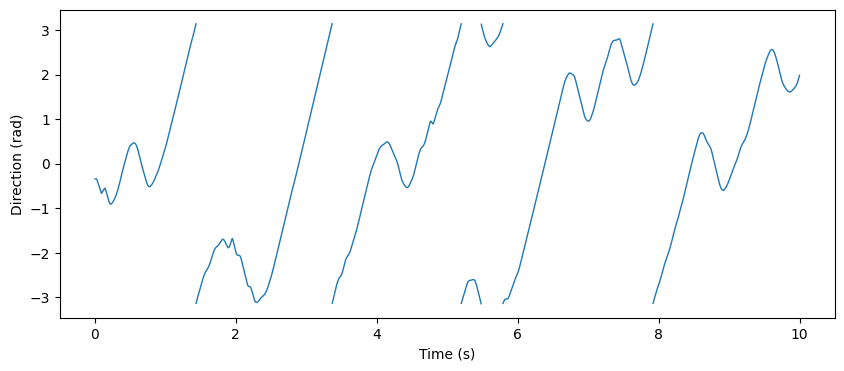

In [15]:
# find the jump points where the difference between two adjacent points is greater than pi
jumps = np.where(np.abs(np.diff(direction)) > np.pi)[0]

# set the jump points to NaN for plotting
direction_plot = direction.copy()
direction_plot[jumps + 1] = np.nan

time_steps = np.array(Ag.history["t"])

fig, ax = plt.subplots(figsize=(10, 4))   
ax.plot(time_steps, direction_plot, lw=1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Direction (rad)')

In [16]:
params = HDParams(adaptation_strength=10, conn_noise=0)
hd_net = HDNet(cell_num=100, params=params)   

velocity_gains = ang_speed/np.max(np.abs(ang_speed))

# simulate the HD network
internal_direction, net_activity, theta_phase, theta_modulation = simulate_hdnet(
    hd_net, direction, velocity_gains, theta_strength=1, theta_cycle_len=100
)

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_3699348/3035990262.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


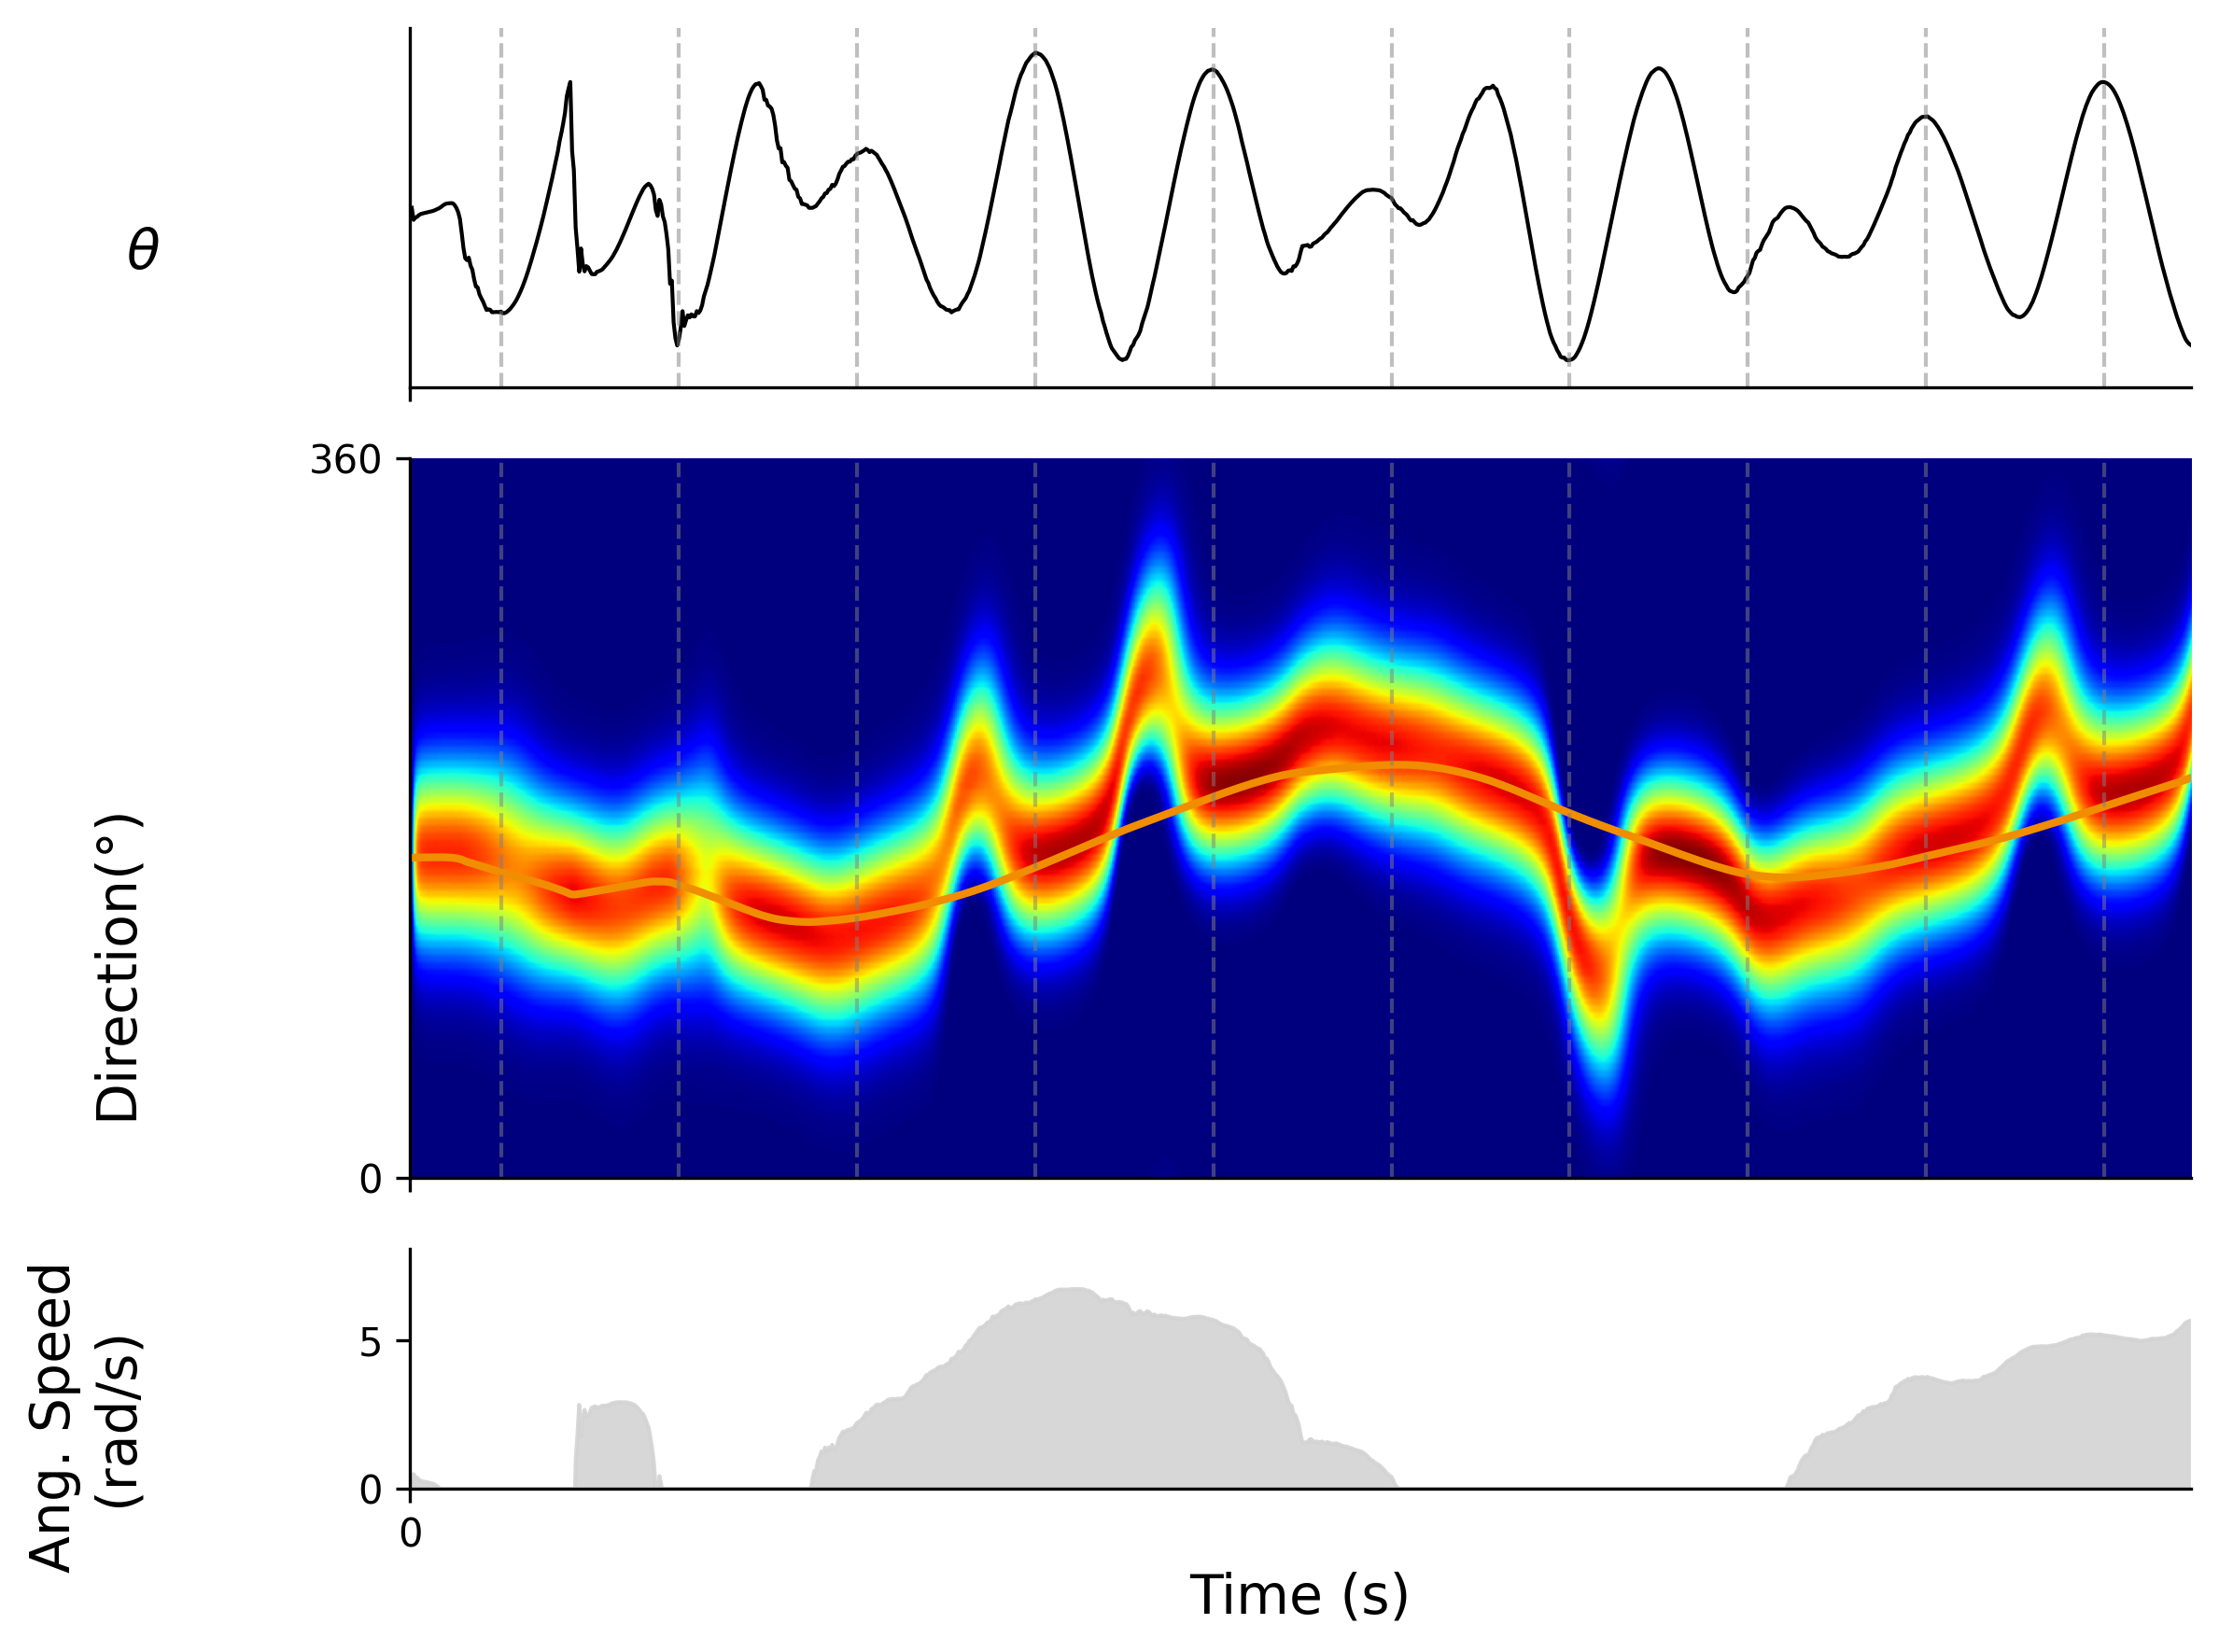

In [17]:
time_steps = np.array(Ag.history["t"])

fig, axes = plt.subplots(
    3,
    1,
    figsize=(8, 6),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.5, 3, 1]},
    dpi=300,
)

ax = axes[0]
ax = plotting.plot_theta_modulation(ax, time_steps, theta_phase, theta_modulation, add_lines=True, atol=1e-2)

ax = axes[1]
ax = plotting.plot_population_activity(ax, time_steps, theta_phase, net_activity, direction, add_lines=True, atol=1e-2)

ax = axes[2]
ax = plotting.plot_angular_speed(ax, time_steps, ang_speed)


for ax in axes:
    sns.despine(ax=ax)
    #align ylabels vertically
    ax.yaxis.set_label_coords(-0.15, 0.3)  # Shift labels left (adjust as needed)
    #labelsize as 14
    ax.tick_params(axis='both', which='major', labelsize=10)
    #labelsize as 14
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)
    # ax.set_xlim(0, time_steps[-1])
    ax.set_xlim(0, 1)



plt.tight_layout()

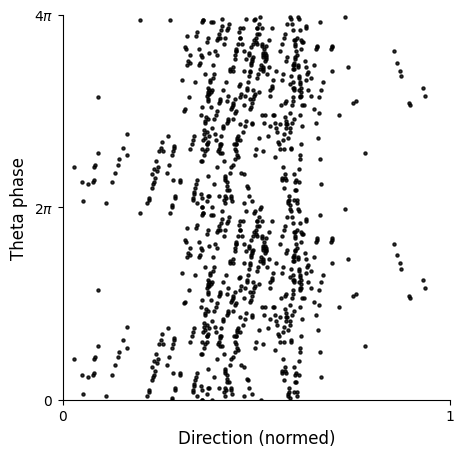

In [19]:


internal_direction = np.array(internal_direction)
net_activity = np.array(net_activity)
theta_phase = np.array(theta_phase)
theta_modulation = np.array(theta_modulation)

cell_num = hd_net.cell_num

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

# ax = plot_phaseprecession(ax, 10, bump_activity_downsampled, Actual_pos, theta_phase)

cell_index = 50
cell_activity = net_activity[:, cell_index]
pos_spike = []
tp_spike = []
#for each Head_direction, theta_phase pair, generate a spike event based on a Poisson process with mean value as r_HD
for i in range(len(direction)):
    pos = direction[i]
    tp = theta_phase[i]
    r = cell_activity[i] 
    #genertae a spike event based on a Poisson process with mean value as r
    spikes = np.random.poisson(r, 1)
    if spikes > 0:
        #save hd and tp
        pos_spike.append(pos)
        tp_spike.append(tp)
pos_spike = np.array(pos_spike)
tp_spike = np.array(tp_spike)

ax.scatter(pos_spike, tp_spike, s=5, color='black', alpha=0.8)

ax.scatter(pos_spike, tp_spike+2*np.pi, s=5, color='black', alpha=0.8)


# ax[0].set_xlabel('Head direction')
ax.set_xlabel('Direction (normed)', fontsize=12)
ax.set_ylabel('Theta phase', fontsize=12)
#activity colorbar
ax.set_xlim(-np.pi*2/3, np.pi*2/3)
ax.set_xticks([-np.pi*2/3, np.pi*2/3])
ax.set_xticklabels([0, 1])
ax.set_ylim(-np.pi, 3*np.pi)
ax.set_yticks([-np.pi, np.pi, 3*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])

#tick size
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



## test code below (ignore)

In [63]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from tqdm import tqdm

Env = Environment(
    params={
    'dimensionality':'2D',
    "scale": 1,
    })

Ag = Agent(Env,params={'dt':0.001, 'speed_mean':5, 'speed_std':0., 'speed_coherence_time':0.8,
                      'rotation_velocity_std':0*np.pi/180, 'rotational_velocity_coherence_time':0.01})

radial_drift_strength = 50
prev_pos = np.array([0.0, 0.0])

radial_drift_velocity = np.array([0.0, 0.0])

for i in tqdm(range(int(10 / Ag.dt))): 
    Ag.update(drift_velocity=radial_drift_velocity)
    current_pos = Ag.pos
    prev_pos = Ag.prev_pos
    dir = current_pos - prev_pos
    #get the prependicular dir
    ortho_dir = np.array([-dir[1], dir[0]])
    radial_drift_velocity = ortho_dir / np.linalg.norm(ortho_dir) * radial_drift_strength #0.5 cm/s


/home/zilong/anaconda3/envs/anticipative_track_gpu/lib/python3.9/site-packages/ratinabox/utils.py:891: UserWarning: Found 1 unexpected params key(s) while initializing Agent object: 'rotation_velocity_std'.
If you intended to set this parameter, ignore this message. To see all default parameters for this class call Agent.get_all_default_params().
  warnings.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2282.80it/s]
